## <center>CS551G - Data Mining and Visualisation</center>

# <center>Assessment I (Task 2): Time Series Classification of User Movement Data</center>

---

## <center>Author: Konstantin Georgiev</center>
### <center>Email: k.georgiev.19@abdn.ac.uk</center>

---

### Wireless Sensor Network dataset

This dataset contains temporal data from a Wireless Sensor Network deployed in real-world office environments. The task is intended as a real-life benchmark in the area of Ambient Assisted Living. The binary classification task consists in predicting the pattern of user movements in real-world office environments from time-series generated by a Wireless Sensor Network.

### Project Structure

1.   <b> [Data acquisition.](#section1) </b>
2.   <b> [Sensor data preprocessing (padding and truncation).](#section2) </b>
3.   <b> [Building the baseline RNN model for time-series classification.](#section3) </b>
4.   <b> [Model evaluation.](#section4) </b>
5.   <b> [Model optimization - version 1.](#section5) </b>
6.   <b> [Model optimization - version 2.](#section6) </b>
7.   <b> [Model optimization - version 3.](#section7) </b>
8.   <b> [Conclusion.](#section8) </b>

#### Libraries

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
import json

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score,
)
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

sns.set(
    style="whitegrid", palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 10]}
)

In [4]:
tf.__version__

'2.1.0'

#### Data Acquisition
<a id='section1'></a>

The <b>Ambient Assisted Living</b> dataset is split into 216 different ```.csv```, which all contain information given by 4 sensors. To process this data, each of these files is loaded and appended to a list of ```DataFrames```. Afterwards, this list is simply concatenated across the x-axis, in order to merge all of the rows and create the full dataset. As the target/label column persists in the ```Ambient_Living_target.csv```, that is loaded individually and the column name is renamed. 

In [ ]:
dataset_path = "./DMV_CS551G_Assessment1_Task2_dataset/"
file_str = "Ambient_Living_"
sequences = list()
dfs = list()
for i in range(1, len(os.listdir(dataset_path)) - 2):
    file_path = dataset_path + file_str + str(i) + ".csv"
    print("Loading ", file_path)
    df = pd.read_csv(file_path, header=0)
    values = df.values
    sequences.append(values)
    dfs.append(df)

print("File loading complete")
sensor_data = pd.concat(dfs, axis=0)
sensor_target = pd.read_csv(
    dataset_path + file_str + "target.csv", index_col="#sequence_ID"
)
sensor_target.index.name = None
sensor_target.columns = ["class_label"]

In [6]:
sensor_data.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [7]:
sensor_target.head()

,class_label
1,1
2,1
3,1
4,1
5,1


The data in this state contains a total of 8080 rows across 4 features and 216 target labels (which is obviously a discrepancy).

In [8]:
print(sensor_data.shape, sensor_target.shape)

(8080, 4) (216, 1)


There are also no missing values in both the target and full datasets.

In [9]:
print(
    "Number of NaNs in sensor data:", len(sensor_data[sensor_data.isnull().any(axis=1)])
)
print(
    "Number of NaNs in target data:",
    len(sensor_target[sensor_target.isnull().any(axis=1)]),
)

Number of NaNs in sensor data: 0
Number of NaNs in target data: 0


All columns have the correct data type (```float``` for the sensor data and ```int``` for the target label - <b>normal</b> or <b>abnormal</b> user movement in the network).

In [10]:
print(sensor_data.dtypes)
print(sensor_target.dtypes)

Sensor 1    float64
Sensor 2    float64
Sensor 3    float64
Sensor 4    float64
dtype: object
class_label    int64
dtype: object


The statistical information regarding the features shows that the values are on a relatively balanced scale.

In [11]:
print(sensor_data.describe())

          Sensor 1     Sensor 2     Sensor 3     Sensor 4
count  8080.000000  8080.000000  8080.000000  8080.000000
mean     -0.078667    -0.122319    -0.172958    -0.106438
std       0.474131     0.448930     0.497846     0.445637
min      -1.000000    -1.000000    -1.000000    -1.000000
25%      -0.454550    -0.466670    -0.590910    -0.446810
50%      -0.045455    -0.155560    -0.155560    -0.100000
75%       0.285710     0.200000     0.142860     0.200000
max       1.000000     1.000000     1.000000     1.000000


There is a very slight imbalance in the class distributions with the <b>-1</b> classes being slightly more.

In [12]:
print(pd.value_counts(sensor_target["class_label"]))

-1    111
 1    105
Name: class_label, dtype: int64


#### Sensor data preprocessing (padding and truncation)
<a id='section2'></a>

The sequences are of varying-length so they will need to padded so the input in the <b>RNN</b> is consistent. For this example, the <b>80th</b> quartile ($54$) is chosen as the maximum threshold for the padding.

In [13]:
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
max_len = pd.Series(len_sequences).quantile(0.8)
pd.Series(len_sequences).describe()

count    216.000000
mean      37.407407
std       14.948306
min       19.000000
25%       25.000000
50%       33.500000
75%       47.750000
max      103.000000
dtype: float64

In [14]:
print("80th quartile of the sequence length across all sequences:", max_len)

80th quartile of the sequence length across all sequences: 54.0


Afterwards, using Keras' ```pad_sequences``` function is used to automatically pad and truncate the sequences to the maximum length. Here, the features are padded with zeros and the sequences are padded and truncated <b>before</b> the real feature values. The result sequences form a <b>3D</b> array with shape ```(216,54,4)```, which now matches the length of the labels.

In [25]:
padded_sequences = pad_sequences(
    sequences,
    maxlen=int(max_len),
    padding="pre",
    truncating="pre",
    dtype="float64",
    value=0.0,
)

In [26]:
print(len(sequences))
print(padded_sequences.shape)

216
(216, 54, 4)


In [27]:
print(padded_sequences[1])

[[ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.      

##### Train-test split

The features are then split into training and test sets in a <b>80/20</b> manner. The label values are also changed to zeros and ones, in order to be accurately processed by the ```sigmoid``` function.

In [28]:
wsn_train = np.array([padded_sequences[i] for i in range(1, 172)])
wsn_test = np.array([padded_sequences[i] for i in range(173, 216)])

wsn_train_target = (
    np.array([list(sensor_target.class_label)[i] for i in range(1, 172)]) + 1
) / 2
wsn_test_target = (
    np.array([list(sensor_target.class_label)[i] for i in range(173, 216)]) + 1
) / 2

In [29]:
print(wsn_train.shape, wsn_test.shape, wsn_train_target.shape, wsn_test_target.shape)

(171, 54, 4) (43, 54, 4) (171,) (43,)


In [30]:
print(wsn_test_target)

[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Building the baseline RNN model for time-series classification
<a id='section3'></a>

##### Model checkpoints and helper-functions

The following are just a few helper-callback functions for saving/loading the model history. In addition, a few <b>Keras</b> callbacks are also defined for <b>Learning rate decay</b> and <b>Early Stopping</b>.

In [31]:
def save_hist(filename, history):
    with open(filename, "w") as write_file:
        json.dump(history, write_file)


def load_hist(filename):
    with open(filename, "r", encoding="utf-8") as read_file:
        train_hist = json.loads(read_file.read())
        return train_hist


learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss", patience=3, verbose=1, factor=0.5, min_lr=0.00001
)

early_stopper = EarlyStopping(monitor="val_loss", patience=25)

##### Baseline model

The baseline <b>RNN</b> model consists of a simple three-layer stacked ```LSTM``` network with a ```Dense sigmoid``` layer, which converts the weights into output probabilities for the predictions. The model is then compiled using a ```binary crossentropy``` logistic loss function, ```RMSprop``` optimizer, which uses an adaptive learning rate and ```accuracy``` as the metric for evaluation.

In [32]:
def build_ts_rnn(max_length, n_feat):
    model = Sequential()
    model.add(Input(shape=(max_length, n_feat)))
    model.add(LSTM(units=16, return_sequences=True))
    model.add(LSTM(units=8, return_sequences=True))
    model.add(LSTM(units=4))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy", optimizer=RMSprop(lr=0.001), metrics=["accuracy"]
    )
    print(model.summary())
    return model

In [33]:
baseline_model = build_ts_rnn(max_length=int(max_len), n_feat=wsn_train.shape[2])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 54, 16)            1344      
_________________________________________________________________
lstm_4 (LSTM)                (None, 54, 8)             800       
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 2,357
Trainable params: 2,357
Non-trainable params: 0
_________________________________________________________________
None


A model checkpointer is also defined to save the weights of the best model found throughout the learning process, based on the validation loss.

In [24]:
model_checkpointer = ModelCheckpoint(
    "./best_rnn_base.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)

The model is then fit on the training set using a validation split of <b>0.2</b> for 200 epochs and a batch size of 64 and the other relevant callbacks.

In [34]:
'''
%%time
baseline_model.load_weights("best_rnn_base.h5")
history = baseline_model.fit(
    wsn_train,
    wsn_train_target,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpointer, learning_rate_reduction, early_stopper],
)
'''

Train on 136 samples, validate on 35 samples
Epoch 1/200
128/136 [===========================>..] - ETA: 0s - loss: 0.7228 - accuracy: 0.4062
Epoch 00001: val_loss improved from inf to 0.66805, saving model to ./best_rnn_base.h5
136/136 [==============================] - 7s 50ms/sample - loss: 0.7237 - accuracy: 0.4118 - val_loss: 0.6680 - val_accuracy: 0.7429
Epoch 2/200
128/136 [===========================>..] - ETA: 0s - loss: 0.7069 - accuracy: 0.3906
Epoch 00002: val_loss did not improve from 0.66805
136/136 [==============================] - 0s 2ms/sample - loss: 0.7054 - accuracy: 0.3971 - val_loss: 0.6981 - val_accuracy: 0.6857
Epoch 3/200
128/136 [===========================>..] - ETA: 0s - loss: 0.6971 - accuracy: 0.4688
Epoch 00003: val_loss did not improve from 0.66805
136/136 [==============================] - 0s 1ms/sample - loss: 0.6982 - accuracy: 0.4632 - val_loss: 0.7063 - val_accuracy: 0.6000
Epoch 4/200
128/136 [===========================>..] - ETA: 0s - loss: 0.69

After each training session the model history is exported to a ```json``` file, so it can be loaded and used for plotting at any time. 

In [35]:
#save_hist("./best_rnn_base.json", str(history.history))
history = eval(load_hist("./best_rnn_base.json"))

##### Evaluation functions
<a id='section4'></a>

Using the model history, the learning curves of the baseline can be plotted. From the initial training session, we can observe that this model is currently overfitting to the training set distribution, as the training loss increases as the validation loss decreases. It even reaches a point to where the validation accuracy is an exponentially low number, close to <b>0</b>. This could be a case of <b>vanishing or exploding</b> gradients affecting the validation data, due to the high learning rate of the model.

In [36]:
def plot_learning_curves(history, load=False):

    if load:
        acc = history["accuracy"]
        val_acc = history["val_accuracy"]
        loss = history["loss"]
        val_loss = history["val_loss"]

    else:
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 15))
    sns.lineplot(x=epochs, y=acc, color="red", label="Training acc", ax=ax[0])
    sns.lineplot(
        x=epochs, y=val_acc, color="blue", label="Validation acc", ax=ax[0]
    ).set(title="Training and validation accuracy")
    sns.lineplot(x=epochs, y=loss, color="red", label="Training loss", ax=ax[1])
    sns.lineplot(
        x=epochs, y=val_loss, color="blue", label="Validation loss", ax=ax[1]
    ).set(title="Training and validation loss")
    plt.show()

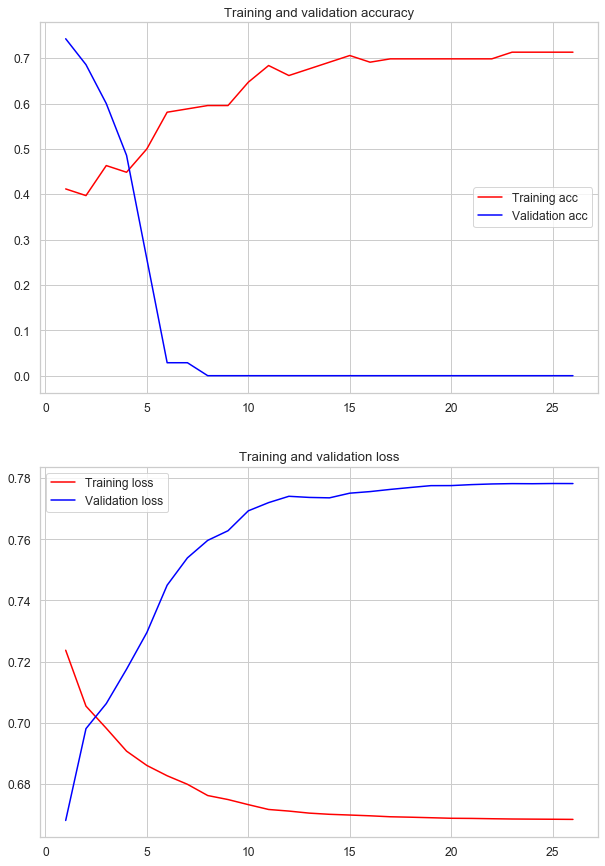

In [37]:
plot_learning_curves(history, load=True)

We can also plot a detailed report of the performance using ```scikit-learn```, including <b>precision, recall, f1-score and confusion matrix</b>. 

In [41]:
def plot_confusion_matrix_and_report(features, labels, model, classes=["0", "1"]):
    test_pred = model.predict(features)
    test_pred = test_pred.T[0]
    print("Classification report")
    cls_pred = np.int32(np.array([1.0 if p > 0.5 else 0.0 for p in test_pred]))
    cls_true = np.int32(np.array(labels))
    #print(cls_true)
    #print(cls_pred)
    print(classification_report(cls_true, cls_pred, target_names=classes))

    # Loss function and accuracy
    test_res = model.evaluate(features, labels, verbose=1)
    print("Loss: {}, Accuracy: {}".format(test_res[0], test_res[1]))

    # Confusion Matrix
    print("Confusion matrix.")

    cm_test = confusion_matrix(cls_true, cls_pred)
    print(cm_test)
    print()
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm_test, cmap=plt.get_cmap("gray"))
    plt.title("Confusion matrix")
    fig.colorbar(cax)
    ax.set_xticklabels([""] + classes)
    ax.set_yticklabels([""] + classes)
    ax.grid(False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Now the evaluation function can be built using these metrics. In this case, <b>10-fold cross validation</b> is performed for the training set. For each split, a new model is fit on the current training set and evaluated on the current validation set. The evaluation includes using the previously implemented performance report function, as well as a mean score of the <b>accuracy, precision, recall and f1-score</b>, which are saved into a list for each iteration. Finally, the same evaluation is also made for the test set, as well.

In [39]:
def evaluate_time_series(
    train_features, train_target, test_features, test_target, rnn_model, k=10
):

    tscv = StratifiedKFold(n_splits=k)
    counter = 0
    train_acc = []
    val_acc = []
    train_precision_recall_f1_score = []
    val_precision_recall_f1_score = []
    for ind_train, ind_val in tqdm(tscv.split(train_features, train_target)):
        counter += 1
        print("CV Split {} ..".format(counter))
        rnn_model.fit(
            wsn_train[ind_train],
            wsn_train_target[ind_train],
            validation_split=0.1,
            epochs=200,
            batch_size=32,
            callbacks=[learning_rate_reduction, early_stopper],
            verbose=0,
        )
        print("Evaluating split..")
        print()
        plot_confusion_matrix_and_report(
            wsn_train[ind_val], wsn_train_target[ind_val], rnn_model
        )

        wsn_train_preds = rnn_model.predict(wsn_train[ind_train]).T[0]
        cls_pred = np.int32(
            np.array([1.0 if p > 0.5 else 0.0 for p in wsn_train_preds])
        )
        cls_true = np.int32(wsn_train_target[ind_train])
        t_precision, t_recall, t_f1score, _ = precision_recall_fscore_support(
            cls_true, cls_pred
        )
        train_precision_recall_f1_score.append((t_precision, t_recall, t_f1score))
        train_acc_split = accuracy_score(cls_true, cls_pred)
        train_acc.append(train_acc_split)

        wsn_val_preds = rnn_model.predict(wsn_train[ind_val]).T[0]
        cls_pred = np.int32(np.array([1.0 if p > 0.5 else 0.0 for p in wsn_val_preds]))
        cls_true = np.int32(wsn_train_target[ind_val])
        v_precision, v_recall, v_f1score, _ = precision_recall_fscore_support(
            cls_true, cls_pred
        )
        val_precision_recall_f1_score.append((v_precision, v_recall, v_f1score))
        val_acc_split = accuracy_score(cls_true, cls_pred)
        val_acc.append(val_acc_split)

    print()
    print("Mean classification scores...")
    print()
    print("Training accuracy:", round(np.mean(train_acc), 3))
    print("Validation accuracy:", round(np.mean(val_acc), 3))
    print(
        "Training precision:",
        round(
            np.mean([i[0] for i in np.nan_to_num(train_precision_recall_f1_score)]), 3
        ),
    )
    print(
        "Training recall:",
        round(
            np.mean([i[1] for i in np.nan_to_num(train_precision_recall_f1_score)]), 3
        ),
    )
    print(
        "Training f1-score:",
        round(
            np.mean([i[2] for i in np.nan_to_num(train_precision_recall_f1_score)]), 3
        ),
    )
    print(
        "Validation precision:",
        round(np.mean([i[0] for i in np.nan_to_num(val_precision_recall_f1_score)]), 3),
    )
    print(
        "Validation recall:",
        round(np.mean([i[1] for i in np.nan_to_num(val_precision_recall_f1_score)]), 3),
    )
    print(
        "Validation f1-score:",
        round(np.mean([i[2] for i in np.nan_to_num(val_precision_recall_f1_score)]), 3),
    )
    print()
    print("Evaluating test set..")
    plot_confusion_matrix_and_report(wsn_test, wsn_test_target, rnn_model)

0it [00:00, ?it/s]

CV Split 1 ..
Evaluating split..

Classification report
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.89      1.00      0.94         8

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18

18/18 [==============================] - 0s 665us/sample - loss: 0.6534 - accuracy: 0.9444
Loss: 0.6533777713775635, Accuracy: 0.9444444179534912
Confusion matrix.
[[9 1]
 [0 8]]



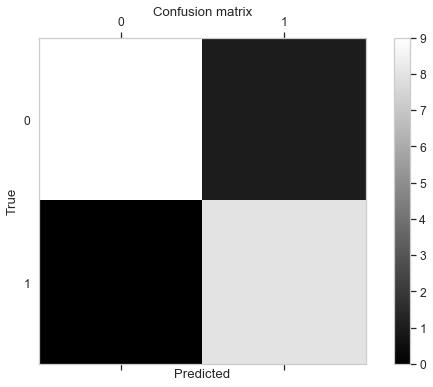

1it [00:09,  9.13s/it]

CV Split 2 ..
Evaluating split..

Classification report
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.73      1.00      0.84         8

    accuracy                           0.82        17
   macro avg       0.86      0.83      0.82        17
weighted avg       0.87      0.82      0.82        17

17/17 [==============================] - 0s 821us/sample - loss: 0.6784 - accuracy: 0.8235
Loss: 0.6784170866012573, Accuracy: 0.8235294222831726
Confusion matrix.
[[6 3]
 [0 8]]



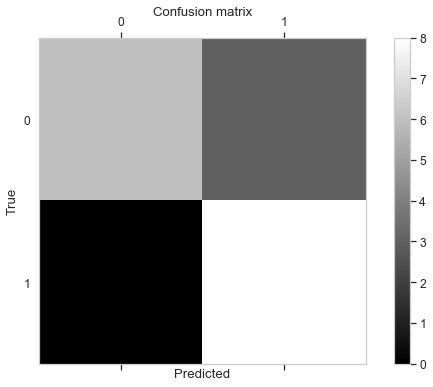

2it [00:17,  8.77s/it]

CV Split 3 ..
Evaluating split..

Classification report
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1]
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.80      1.00      0.89         8

    accuracy                           0.88        17
   macro avg       0.90      0.89      0.88        17
weighted avg       0.91      0.88      0.88        17

17/17 [==============================] - 0s 939us/sample - loss: 0.6569 - accuracy: 0.8824
Loss: 0.6569390296936035, Accuracy: 0.8823529481887817
Confusion matrix.
[[7 2]
 [0 8]]



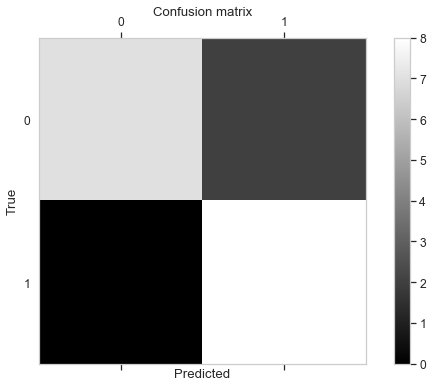

3it [00:32, 10.74s/it]

CV Split 4 ..
Evaluating split..

Classification report
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.47      1.00      0.64         8

    accuracy                           0.47        17
   macro avg       0.24      0.50      0.32        17
weighted avg       0.22      0.47      0.30        17

17/17 [==============================] - 0s 704us/sample - loss: 0.6834 - accuracy: 0.4706
Loss: 0.6834161877632141, Accuracy: 0.47058823704719543
Confusion matrix.
[[0 9]
 [0 8]]



c:\users\user\.conda\envs\tf-std\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


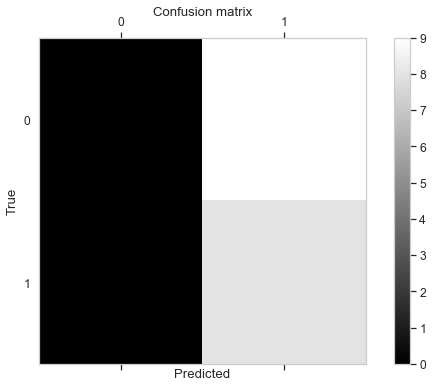

4it [00:39,  9.63s/it]

CV Split 5 ..
Evaluating split..

Classification report
[0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.47      1.00      0.64         8

    accuracy                           0.47        17
   macro avg       0.24      0.50      0.32        17
weighted avg       0.22      0.47      0.30        17

17/17 [==============================] - 0s 761us/sample - loss: 0.6870 - accuracy: 0.4706
Loss: 0.6869860291481018, Accuracy: 0.47058823704719543
Confusion matrix.
[[0 9]
 [0 8]]



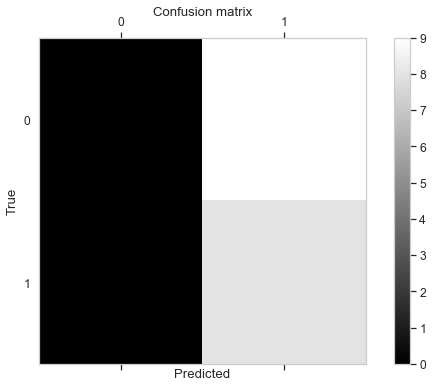

5it [00:46,  8.86s/it]

CV Split 6 ..
Evaluating split..

Classification report
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.50      1.00      0.67         8

    accuracy                           0.53        17
   macro avg       0.75      0.56      0.43        17
weighted avg       0.76      0.53      0.42        17

17/17 [==============================] - 0s 763us/sample - loss: 0.6821 - accuracy: 0.5294
Loss: 0.6821331977844238, Accuracy: 0.529411792755127
Confusion matrix.
[[1 8]
 [0 8]]



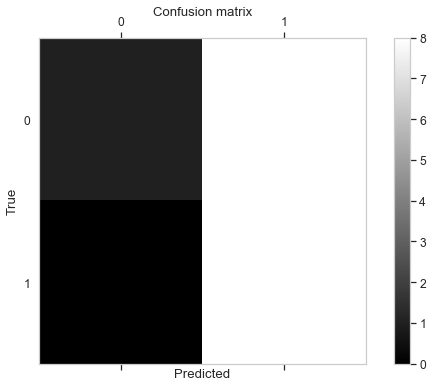

6it [00:54,  8.49s/it]

CV Split 7 ..
Evaluating split..

Classification report
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1]
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.50      0.88      0.64         8

    accuracy                           0.53        17
   macro avg       0.58      0.55      0.48        17
weighted avg       0.59      0.53      0.48        17

17/17 [==============================] - 0s 793us/sample - loss: 0.6862 - accuracy: 0.5294
Loss: 0.6862193942070007, Accuracy: 0.529411792755127
Confusion matrix.
[[2 7]
 [1 7]]



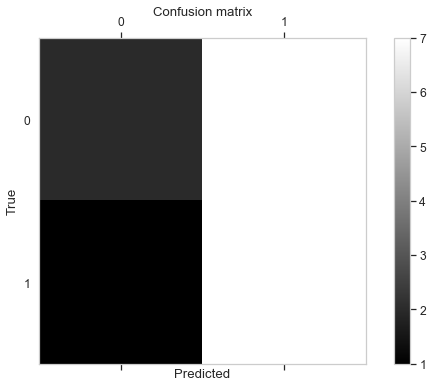

7it [01:01,  8.17s/it]

CV Split 8 ..
Evaluating split..

Classification report
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.44      1.00      0.61         7

    accuracy                           0.47        17
   macro avg       0.72      0.55      0.40        17
weighted avg       0.77      0.47      0.36        17

17/17 [==============================] - 0s 704us/sample - loss: 0.7002 - accuracy: 0.4706
Loss: 0.7001502513885498, Accuracy: 0.47058823704719543
Confusion matrix.
[[1 9]
 [0 7]]



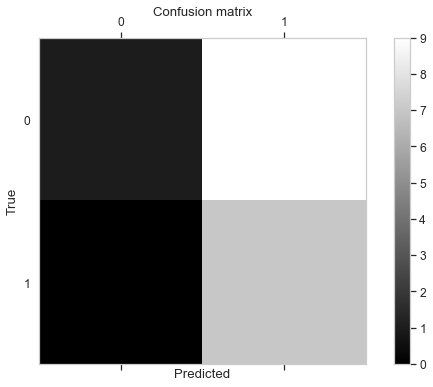

8it [01:08,  7.81s/it]

CV Split 9 ..
Evaluating split..

Classification report
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.41      1.00      0.58         7

    accuracy                           0.41        17
   macro avg       0.21      0.50      0.29        17
weighted avg       0.17      0.41      0.24        17

17/17 [==============================] - 0s 704us/sample - loss: 0.6845 - accuracy: 0.4118
Loss: 0.684504508972168, Accuracy: 0.4117647111415863
Confusion matrix.
[[ 0 10]
 [ 0  7]]



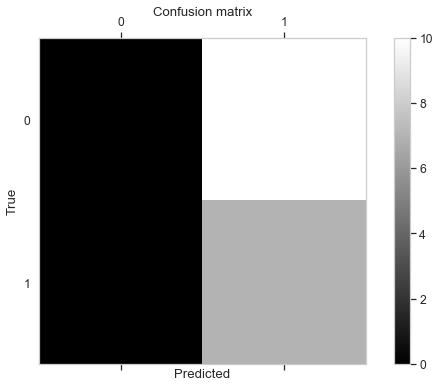

9it [01:15,  7.54s/it]

CV Split 10 ..
Evaluating split..

Classification report
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.41      1.00      0.58         7

    accuracy                           0.41        17
   macro avg       0.21      0.50      0.29        17
weighted avg       0.17      0.41      0.24        17

17/17 [==============================] - 0s 645us/sample - loss: 0.8412 - accuracy: 0.4118
Loss: 0.8411874771118164, Accuracy: 0.4117647111415863
Confusion matrix.
[[ 0 10]
 [ 0  7]]



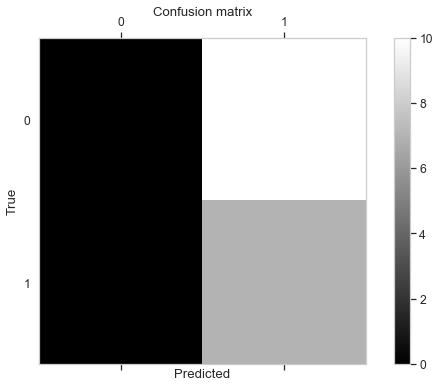

10it [02:10, 13.06s/it]


Mean classification scores...

Training accuracy: 0.595
Validation accuracy: 0.594
Training precision: 0.729
Training recall: 0.629
Training f1-score: 0.559
Validation precision: 0.564
Validation recall: 0.633
Validation f1-score: 0.518

Evaluating test set..
Classification report
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1]
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        16
           1       0.64      1.00      0.78        27

    accuracy                           0.65        43
   macro avg       0.82      0.53      0.45        43
weighted avg       0.78      0.65      0.54        43

43/43 [==============================] - 0s 613us/sample - loss: 0.6268 - accuracy: 0.6512


Loss: 0.626777567142664, Accuracy: 0.6511628031730652
Confusion matrix.
[[ 1 15]
 [ 0 27]]



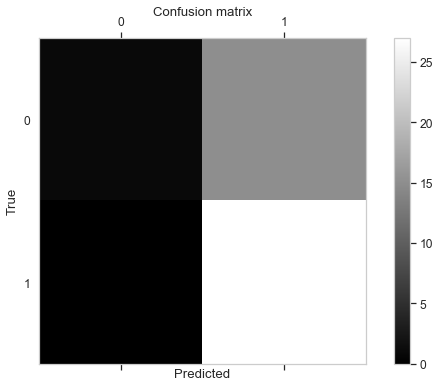

In [40]:
evaluate_time_series(
    wsn_train, wsn_train_target, wsn_test, wsn_test_target, baseline_model
)

From these scores for the baseline model, we can observe that in some splits the model performs quite well. However, in most cases, there is a clear lack of performance in identifying the `0` class. That is, in most splits the model learns to predict almost only a normal condition of the network (`1`), which leads to scores that are just slightly better than random.

#### Optimization step - version 1
<a id='section5'></a>

In order to try to improve this 'slightly better than random' performance, in the first optimization step, I will remove the last <b>LSTM</b> layer and increase the number of units in the first two layers (512 and 128). In addition, I am also going to experiment with the `Adam` optimization function, as an alternative.

In [42]:
def build_ts_rnn_opt_1(max_length, n_feat, emb_size=4):
    model = Sequential()
    model.add(Input(shape=(max_length, n_feat)))
    model.add(LSTM(units=512, return_sequences=True))
    model.add(LSTM(units=128))
    # model.add(LSTM(units=4))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"]
    )
    print(model.summary())
    return model

In [43]:
opt_model = build_ts_rnn_opt_1(max_length=int(max_len), n_feat=wsn_train.shape[2])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 54, 512)           1058816   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,387,137
Trainable params: 1,387,137
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
model_checkpointer = ModelCheckpoint(
    "./best_rnn_opt1.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)

In [45]:
'''
%%time
baseline_model.load_weights('best_rnn_opt1.h5')
history = opt_model.fit(
    wsn_train,
    wsn_train_target,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[model_checkpointer, learning_rate_reduction, early_stopper],
)
'''

Train on 136 samples, validate on 35 samples
Epoch 1/200
128/136 [===========================>..] - ETA: 0s - loss: 0.6735 - accuracy: 0.5703
Epoch 00001: val_loss improved from inf to 1.07266, saving model to ./best_rnn_opt1.h5
136/136 [==============================] - 6s 46ms/sample - loss: 0.6647 - accuracy: 0.5882 - val_loss: 1.0727 - val_accuracy: 0.0857
Epoch 2/200
128/136 [===========================>..] - ETA: 0s - loss: 0.5814 - accuracy: 0.6641
Epoch 00002: val_loss improved from 1.07266 to 0.78347, saving model to ./best_rnn_opt1.h5
136/136 [==============================] - 2s 15ms/sample - loss: 0.5700 - accuracy: 0.6838 - val_loss: 0.7835 - val_accuracy: 0.7429
Epoch 3/200
128/136 [===========================>..] - ETA: 0s - loss: 0.5611 - accuracy: 0.7500
Epoch 00003: val_loss did not improve from 0.78347
136/136 [==============================] - 2s 15ms/sample - loss: 0.5517 - accuracy: 0.7500 - val_loss: 1.6035 - val_accuracy: 0.3143
Epoch 4/200
128/136 [============

In [46]:
#save_hist("./best_rnn_opt1.json", str(history.history))
history = eval(load_hist("./best_rnn_opt1.json"))

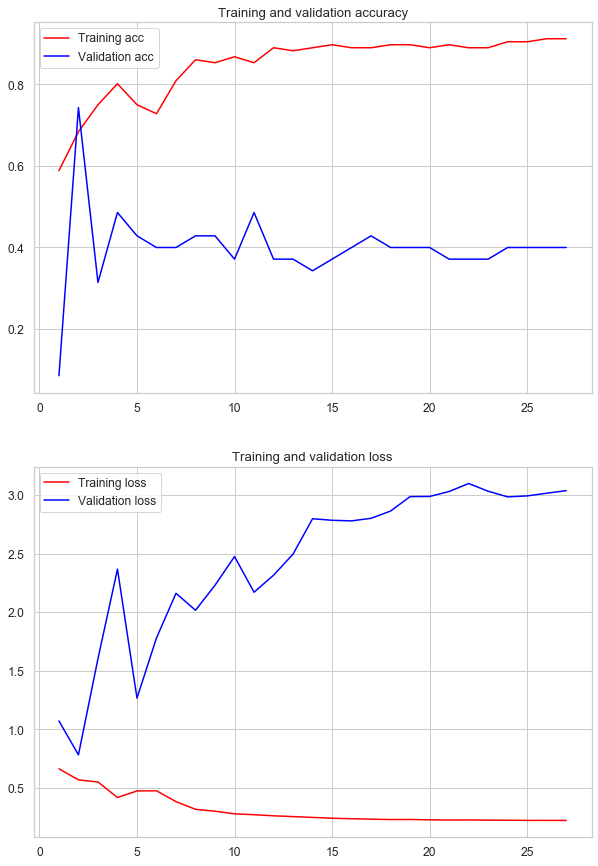

In [47]:
plot_learning_curves(history, load=True)

The learning curve here is slightly more normalized than the baseline, but there are still clear signs of overfitting and the validation accuracy seems to converge at around <b>40%</b>.

0it [00:00, ?it/s]

CV Split 1 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

18/18 [==============================] - 0s 3ms/sample - loss: 0.0163 - accuracy: 1.0000
Loss: 0.016257058829069138, Accuracy: 1.0
Confusion matrix.
[[10  0]
 [ 0  8]]



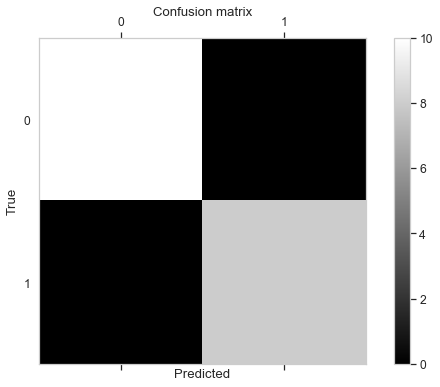

1it [01:09, 69.39s/it]

CV Split 2 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.75      0.75      0.75         8

    accuracy                           0.76        17
   macro avg       0.76      0.76      0.76        17
weighted avg       0.76      0.76      0.76        17

17/17 [==============================] - 0s 4ms/sample - loss: 0.4263 - accuracy: 0.7647
Loss: 0.4263079762458801, Accuracy: 0.7647058963775635
Confusion matrix.
[[7 2]
 [2 6]]



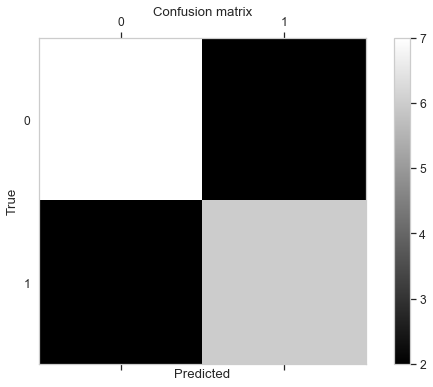

2it [02:14, 68.15s/it]

CV Split 3 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.88      0.88      0.88         8

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.3093 - accuracy: 0.8824
Loss: 0.30927175283432007, Accuracy: 0.8823529481887817
Confusion matrix.
[[8 1]
 [1 7]]



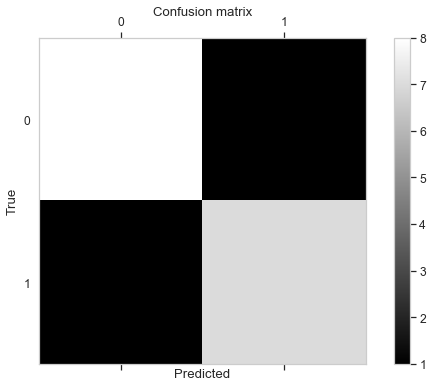

3it [03:19, 67.30s/it]

CV Split 4 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.53      1.00      0.70         8

    accuracy                           0.59        17
   macro avg       0.77      0.61      0.53        17
weighted avg       0.78      0.59      0.52        17

17/17 [==============================] - 0s 4ms/sample - loss: 0.6548 - accuracy: 0.5882
Loss: 0.6547955274581909, Accuracy: 0.5882353186607361
Confusion matrix.
[[2 7]
 [0 8]]



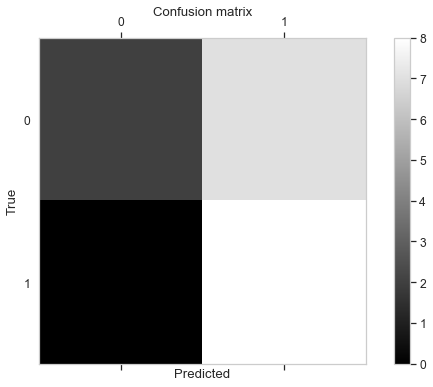

4it [04:16, 64.04s/it]

CV Split 5 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.86      0.75      0.80         8

    accuracy                           0.82        17
   macro avg       0.83      0.82      0.82        17
weighted avg       0.83      0.82      0.82        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.3226 - accuracy: 0.8235
Loss: 0.32259035110473633, Accuracy: 0.8235294222831726
Confusion matrix.
[[8 1]
 [2 6]]



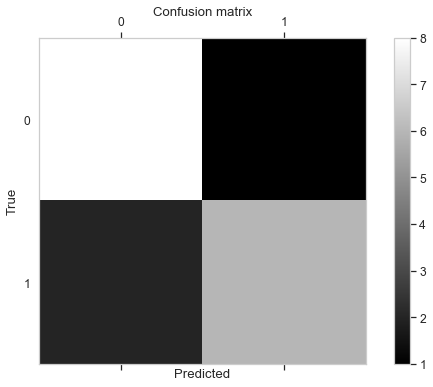

5it [05:12, 61.66s/it]

CV Split 6 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.88      0.88      0.88         8

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17

17/17 [==============================] - 0s 4ms/sample - loss: 0.3255 - accuracy: 0.8824
Loss: 0.325532466173172, Accuracy: 0.8823529481887817
Confusion matrix.
[[8 1]
 [1 7]]



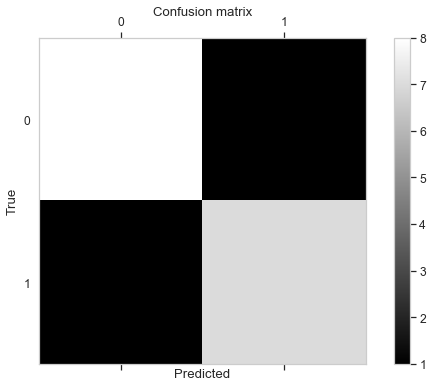

6it [06:11, 60.85s/it]

CV Split 7 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.89      1.00      0.94         8

    accuracy                           0.94        17
   macro avg       0.94      0.94      0.94        17
weighted avg       0.95      0.94      0.94        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.1551 - accuracy: 0.9412
Loss: 0.15507249534130096, Accuracy: 0.9411764740943909
Confusion matrix.
[[8 1]
 [0 8]]



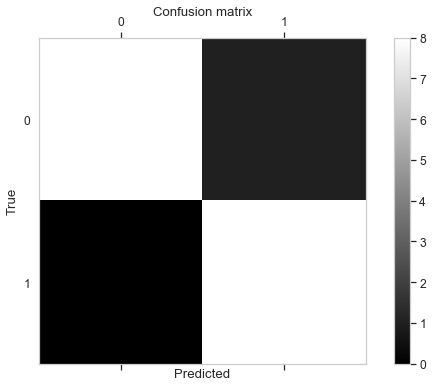

7it [07:08, 59.66s/it]

CV Split 8 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.88      1.00      0.93         7

    accuracy                           0.94        17
   macro avg       0.94      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.0997 - accuracy: 0.9412
Loss: 0.09970894455909729, Accuracy: 0.9411764740943909
Confusion matrix.
[[9 1]
 [0 7]]



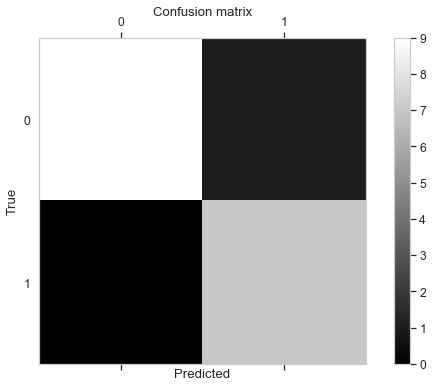

8it [08:07, 59.51s/it]

CV Split 9 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         7

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

17/17 [==============================] - 0s 5ms/sample - loss: 0.0566 - accuracy: 1.0000
Loss: 0.056591905653476715, Accuracy: 1.0
Confusion matrix.
[[10  0]
 [ 0  7]]



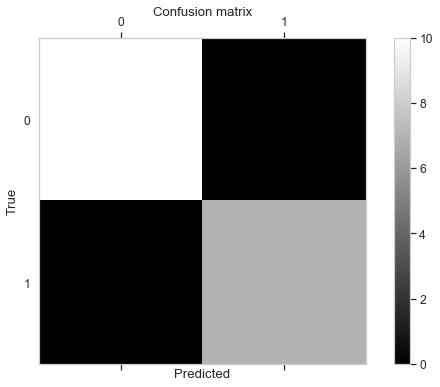

9it [09:03, 58.39s/it]

CV Split 10 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.44      1.00      0.61         7

    accuracy                           0.47        17
   macro avg       0.72      0.55      0.40        17
weighted avg       0.77      0.47      0.36        17

17/17 [==============================] - 0s 5ms/sample - loss: 5.2137 - accuracy: 0.4706
Loss: 5.213680267333984, Accuracy: 0.47058823704719543
Confusion matrix.
[[1 9]
 [0 7]]



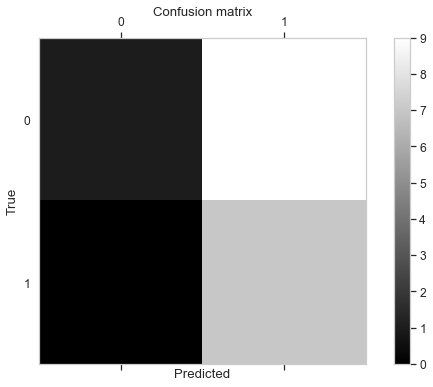

10it [10:09, 60.93s/it]



Mean classification scores...

Training accuracy: 0.866
Validation accuracy: 0.829
Training precision: 0.867
Training recall: 0.87
Training f1-score: 0.866
Validation precision: 0.872
Validation recall: 0.84
Validation f1-score: 0.816

Evaluating test set..
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.63      1.00      0.77        27

    accuracy                           0.63        43
   macro avg       0.31      0.50      0.39        43
weighted avg       0.39      0.63      0.48        43

32/43 [=====================>........] - ETA: 0s - loss: 1.4396 - accuracy: 0.8438

c:\users\user\.conda\envs\tf-std\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


43/43 [==============================] - 0s 4ms/sample - loss: 3.3865 - accuracy: 0.6279
Loss: 3.386458707410236, Accuracy: 0.6279069781303406
Confusion matrix.
[[ 0 16]
 [ 0 27]]



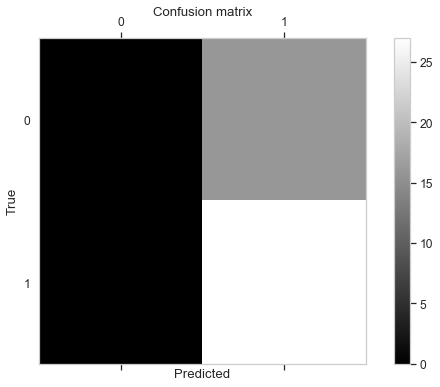

In [48]:
evaluate_time_series(wsn_train, wsn_train_target, wsn_test, wsn_test_target, opt_model)

The CV results are almost misleadingly high, as all splits, except for the last two score nearly perfect results. However, if we look at the test set results, the model clearly fails to identify any of the `0` classes, which proves that this still is far from a robust solution.

#### Optimization step - version 2
<a id='section6'></a>

In the second version, I will introduce a few extra layers to the network. These include a <b>50%</b> ```dropout``` layer between the <b>LSTM</b> layers, as well as a second dense layer with <b>64</b> units followed by another ```dropout``` layer, for regularization purposes, which might hopefully stabilize the performance of the network. 

In [49]:
def build_ts_rnn_opt_2(max_length, n_feat, emb_size=4):
    model = Sequential()
    model.add(Input(shape=(max_length, n_feat)))
    model.add(LSTM(units=512, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=128))
    # model.add(LSTM(units=4))
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"]
    )
    print(model.summary())
    return model

In [50]:
opt_model = build_ts_rnn_opt_2(max_length=int(max_len), n_feat=wsn_train.shape[2])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 54, 512)           1058816   
_________________________________________________________________
dropout (Dropout)            (None, 54, 512)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,395,329
Trainable params: 1,395,329
Non-trainable params: 0
____________________________________________

In [51]:
model_checkpointer = ModelCheckpoint(
    "./best_rnn_opt2.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)

In [52]:
'''
%%time
baseline_model.load_weights('best_rnn_opt2.h5')
history = opt_model.fit(
    wsn_train,
    wsn_train_target,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[model_checkpointer, learning_rate_reduction],
)
'''

Train on 136 samples, validate on 35 samples
Epoch 1/200
128/136 [===========================>..] - ETA: 0s - loss: 0.6888 - accuracy: 0.5391
Epoch 00001: val_loss improved from inf to 0.72092, saving model to ./best_rnn_opt2.h5
136/136 [==============================] - 6s 47ms/sample - loss: 0.6896 - accuracy: 0.5294 - val_loss: 0.7209 - val_accuracy: 0.2571
Epoch 2/200
128/136 [===========================>..] - ETA: 0s - loss: 0.6684 - accuracy: 0.6016
Epoch 00002: val_loss did not improve from 0.72092
136/136 [==============================] - 2s 14ms/sample - loss: 0.6684 - accuracy: 0.6029 - val_loss: 0.7572 - val_accuracy: 0.2286
Epoch 3/200
128/136 [===========================>..] - ETA: 0s - loss: 0.6701 - accuracy: 0.5781
Epoch 00003: val_loss did not improve from 0.72092
136/136 [==============================] - 2s 15ms/sample - loss: 0.6648 - accuracy: 0.6029 - val_loss: 0.7862 - val_accuracy: 0.2286
Epoch 4/200
128/136 [===========================>..] - ETA: 0s - loss: 0.

In [53]:
#save_hist("./best_rnn_opt2.json", str(history.history))
history = eval(load_hist("./best_rnn_opt2.json"))

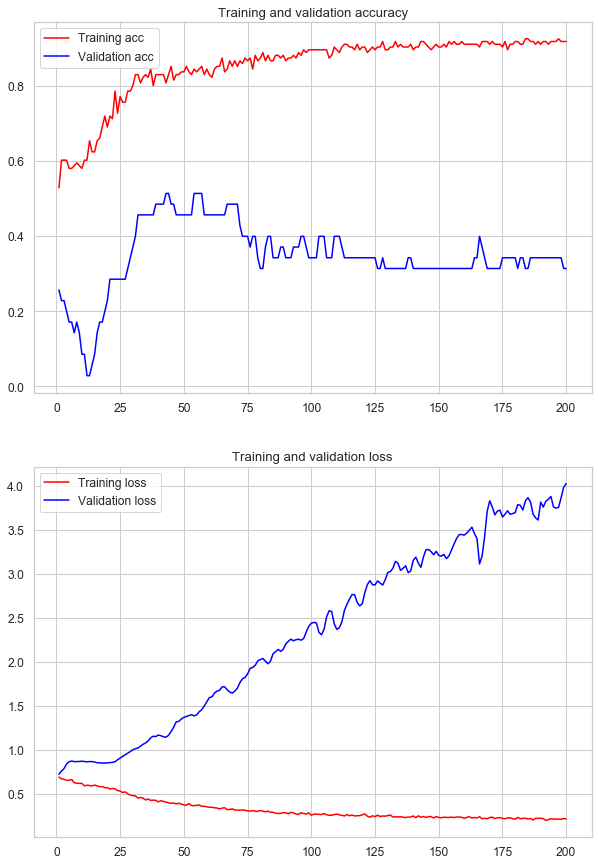

In [54]:
plot_learning_curves(history, load=True)

Even for a longer period of training, with this configuration, the overfitting is still clearly present and even worse than the previous version.

0it [00:00, ?it/s]

CV Split 1 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

18/18 [==============================] - 0s 4ms/sample - loss: 0.0221 - accuracy: 1.0000
Loss: 0.02206294797360897, Accuracy: 1.0
Confusion matrix.
[[10  0]
 [ 0  8]]



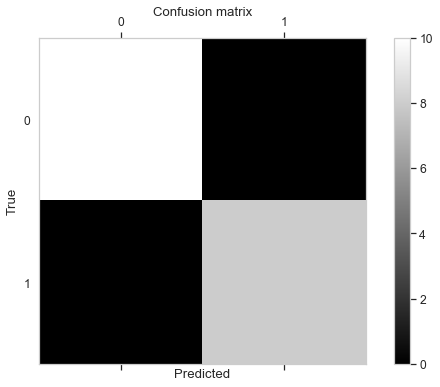

1it [01:39, 99.03s/it]

CV Split 2 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.75      0.75      0.75         8

    accuracy                           0.76        17
   macro avg       0.76      0.76      0.76        17
weighted avg       0.76      0.76      0.76        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.4729 - accuracy: 0.7647
Loss: 0.4728710949420929, Accuracy: 0.7647058963775635
Confusion matrix.
[[7 2]
 [2 6]]



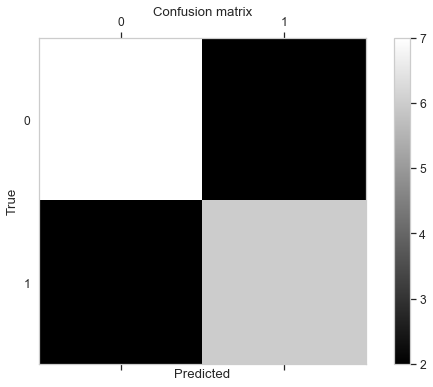

2it [02:32, 85.50s/it]

CV Split 3 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.88      0.88      0.88         8

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.3218 - accuracy: 0.8824
Loss: 0.3218470811843872, Accuracy: 0.8823529481887817
Confusion matrix.
[[8 1]
 [1 7]]



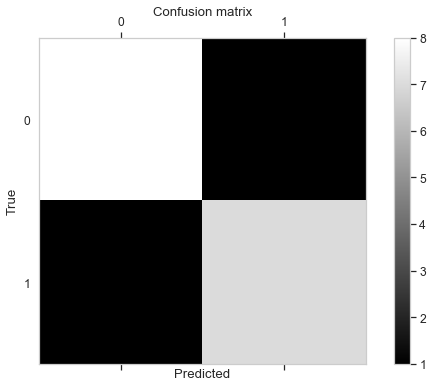

3it [03:51, 83.43s/it]

CV Split 4 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.75      0.75      0.75         8

    accuracy                           0.76        17
   macro avg       0.76      0.76      0.76        17
weighted avg       0.76      0.76      0.76        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.4027 - accuracy: 0.7647
Loss: 0.40271666646003723, Accuracy: 0.7647058963775635
Confusion matrix.
[[7 2]
 [2 6]]



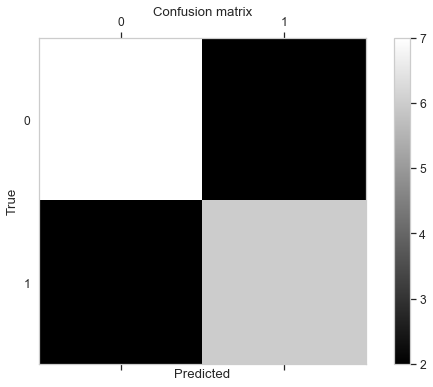

4it [05:28, 87.43s/it]

CV Split 5 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.88      0.88      0.88         8

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17

17/17 [==============================] - 0s 4ms/sample - loss: 0.2484 - accuracy: 0.8824
Loss: 0.2484283447265625, Accuracy: 0.8823529481887817
Confusion matrix.
[[8 1]
 [1 7]]



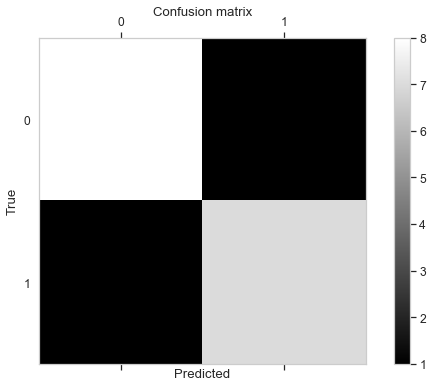

5it [06:48, 85.40s/it]

CV Split 6 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.88      0.88      0.88         8

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.4528 - accuracy: 0.8824
Loss: 0.45284101366996765, Accuracy: 0.8823529481887817
Confusion matrix.
[[8 1]
 [1 7]]



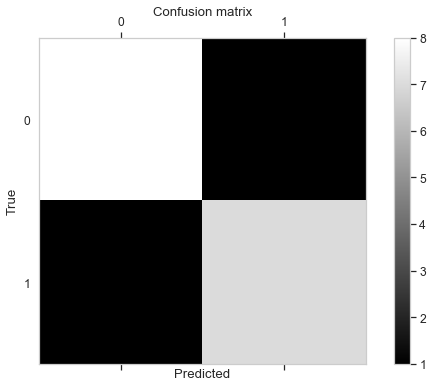

6it [07:44, 76.34s/it]

CV Split 7 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.88      0.88      0.88         8

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.2363 - accuracy: 0.8824
Loss: 0.2362579107284546, Accuracy: 0.8823529481887817
Confusion matrix.
[[8 1]
 [1 7]]



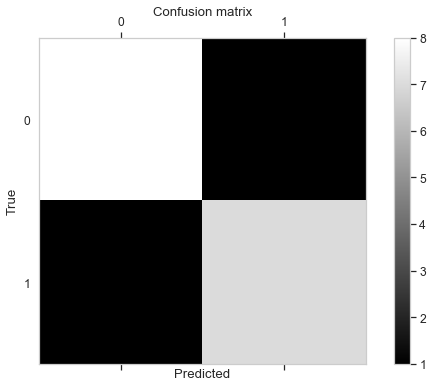

7it [08:46, 72.24s/it]

CV Split 8 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.86      0.86      0.86         7

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17

17/17 [==============================] - 0s 4ms/sample - loss: 0.3793 - accuracy: 0.8824
Loss: 0.3793368637561798, Accuracy: 0.8823529481887817
Confusion matrix.
[[9 1]
 [1 6]]



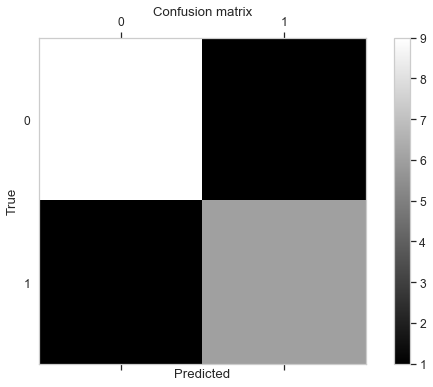

8it [09:53, 70.42s/it]

CV Split 9 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.78      1.00      0.88         7

    accuracy                           0.88        17
   macro avg       0.89      0.90      0.88        17
weighted avg       0.91      0.88      0.88        17

17/17 [==============================] - 0s 3ms/sample - loss: 0.2910 - accuracy: 0.8824
Loss: 0.29100367426872253, Accuracy: 0.8823529481887817
Confusion matrix.
[[8 2]
 [0 7]]



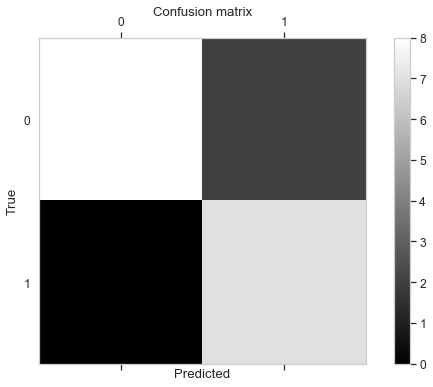

9it [10:50, 66.54s/it]

CV Split 10 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.44      1.00      0.61         7

    accuracy                           0.47        17
   macro avg       0.72      0.55      0.40        17
weighted avg       0.77      0.47      0.36        17

17/17 [==============================] - 0s 3ms/sample - loss: 5.6609 - accuracy: 0.4706
Loss: 5.660935401916504, Accuracy: 0.47058823704719543
Confusion matrix.
[[1 9]
 [0 7]]



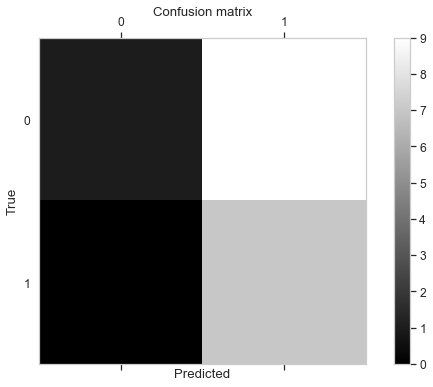

10it [11:55, 71.57s/it]



Mean classification scores...

Training accuracy: 0.863
Validation accuracy: 0.829
Training precision: 0.863
Training recall: 0.865
Training f1-score: 0.862
Validation precision: 0.854
Validation recall: 0.838
Validation f1-score: 0.821

Evaluating test set..
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.63      1.00      0.77        27

    accuracy                           0.63        43
   macro avg       0.31      0.50      0.39        43
weighted avg       0.39      0.63      0.48        43

32/43 [=====================>........] - ETA: 0s - loss: 1.5384 - accuracy: 0.8438

c:\users\user\.conda\envs\tf-std\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


43/43 [==============================] - 0s 5ms/sample - loss: 2.7292 - accuracy: 0.6279
Loss: 2.7292077485905137, Accuracy: 0.6279069781303406
Confusion matrix.
[[ 0 16]
 [ 0 27]]



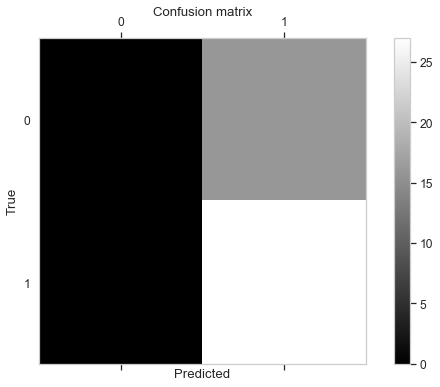

In [55]:
evaluate_time_series(wsn_train, wsn_train_target, wsn_test, wsn_test_target, opt_model)

There is also not much to add regarding the CV results, as the results are nearly identical to the previous version (good results in the splits and bad performance in the test set).

#### Optimization step - version 3
<a id='section7'></a>

As a final attempt, I will reuse the first stacked architecture from the baseline model, but add a ```dropout``` layer between each ```LSTM``` layer for regularization with an increasing ratio, with a tuned learning rate of $0.02$.

In [56]:
def build_ts_rnn_opt_3(max_length, n_feat):
    model = Sequential()
    model.add(Input(shape=(max_length, n_feat)))
    # model.add(Dropout(0.5))
    model.add(LSTM(units=16, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=4, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=2))
    model.add(Dropout(0.5))
    # model.add(LSTM(units=4))
    # model.add(Dense(64))
    # model.add(Dropout(0.5))
    # model.add(LSTM(units=16, return_sequences=True))
    # model.add(Dropout(0.5))
    # model.add(LSTM(units=8))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(lr=0.02), metrics=["accuracy"]
    )
    print(model.summary())
    return model

In [57]:
opt_model = build_ts_rnn_opt_3(max_length=int(max_len), n_feat=wsn_train.shape[2])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 54, 16)            1344      
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 16)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 54, 4)             336       
_________________________________________________________________
dropout_3 (Dropout)          (None, 54, 4)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 2)                 56        
_________________________________________________________________
dropout_4 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [58]:
model_checkpointer = ModelCheckpoint(
    "./best_rnn_opt3.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)

In [59]:
'''
%%time
baseline_model.load_weights('best_rnn_opt3.h5')
history = opt_model.fit(
    wsn_train,
    wsn_train_target,
    validation_split=0.15,
    epochs=100,
    callbacks=[model_checkpointer, learning_rate_reduction, early_stopper],
)
'''

Train on 145 samples, validate on 26 samples
Epoch 1/100
128/145 [=========================>....] - ETA: 0s - loss: 0.6927 - accuracy: 0.5234
Epoch 00001: val_loss improved from inf to 0.76591, saving model to ./best_rnn_opt3.h5
145/145 [==============================] - 6s 44ms/sample - loss: 0.6942 - accuracy: 0.5103 - val_loss: 0.7659 - val_accuracy: 0.0000e+00
Epoch 2/100
128/145 [=========================>....] - ETA: 0s - loss: 0.6981 - accuracy: 0.4766
Epoch 00002: val_loss improved from 0.76591 to 0.72008, saving model to ./best_rnn_opt3.h5
145/145 [==============================] - 0s 2ms/sample - loss: 0.6968 - accuracy: 0.4759 - val_loss: 0.7201 - val_accuracy: 0.0000e+00
Epoch 3/100
128/145 [=========================>....] - ETA: 0s - loss: 0.6774 - accuracy: 0.5859
Epoch 00003: val_loss did not improve from 0.72008
145/145 [==============================] - 0s 2ms/sample - loss: 0.6767 - accuracy: 0.5862 - val_loss: 0.7906 - val_accuracy: 0.0000e+00
Epoch 4/100
128/145 [==

In [60]:
#save_hist("./best_rnn_opt3.json", str(history.history))
history = eval(load_hist("./best_rnn_opt3.json"))

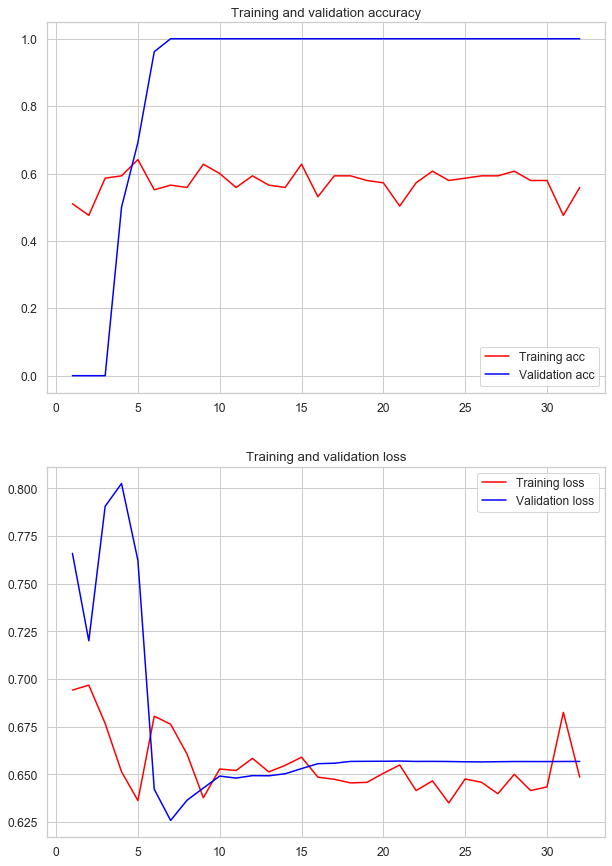

In [61]:
plot_learning_curves(history, load=True)

In this case, finally we get some positive results. The validation accuracy here seems to converge at around <b>60%</b>, which means that this model is <b>underfit</b>, but at least now the validation and training loss curves are very close together, meaning that the overfitting problem has been fixed with some rigorous tuning.

0it [00:00, ?it/s]

CV Split 1 ..

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1e-05.
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       0.00      0.00      0.00         8

    accuracy                           0.56        18
   macro avg       0.28      0.50      0.36        18
weighted avg       0.31      0.56      0.40        18

18/18 [==============================] - 0s 606us/sample - loss: 0.6894 - accuracy: 0.5556
Loss: 0.6893649697303772, Accuracy: 0.5555555820465088
Confusion matrix.
[[10  0]
 [ 8  0]]



c:\users\user\.conda\envs\tf-std\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


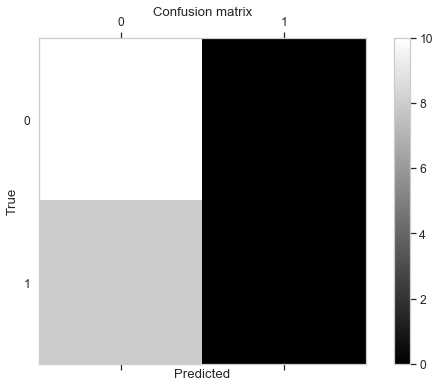

1it [00:50, 50.83s/it]

CV Split 2 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       0.00      0.00      0.00         8

    accuracy                           0.53        17
   macro avg       0.26      0.50      0.35        17
weighted avg       0.28      0.53      0.37        17

17/17 [==============================] - 0s 587us/sample - loss: 0.6920 - accuracy: 0.5294
Loss: 0.6919644474983215, Accuracy: 0.529411792755127
Confusion matrix.
[[9 0]
 [8 0]]



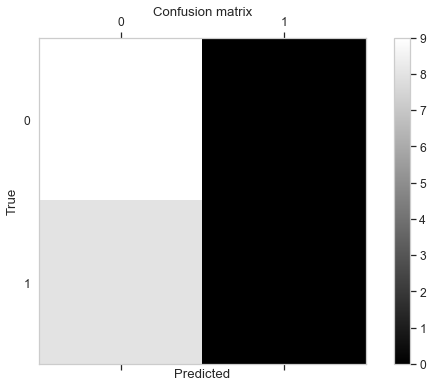

2it [01:39, 50.26s/it]

CV Split 3 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       0.00      0.00      0.00         8

    accuracy                           0.53        17
   macro avg       0.26      0.50      0.35        17
weighted avg       0.28      0.53      0.37        17

17/17 [==============================] - 0s 704us/sample - loss: 0.6910 - accuracy: 0.5294
Loss: 0.691002368927002, Accuracy: 0.529411792755127
Confusion matrix.
[[9 0]
 [8 0]]



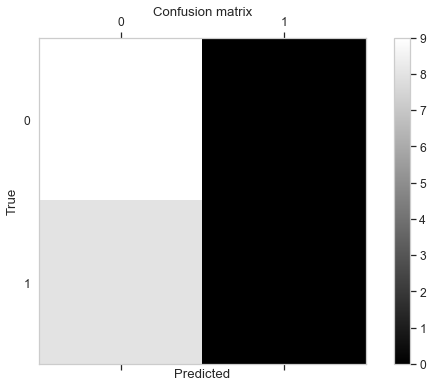

3it [02:28, 49.82s/it]

CV Split 4 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       0.00      0.00      0.00         8

    accuracy                           0.53        17
   macro avg       0.26      0.50      0.35        17
weighted avg       0.28      0.53      0.37        17

17/17 [==============================] - 0s 647us/sample - loss: 0.6913 - accuracy: 0.5294
Loss: 0.6913197040557861, Accuracy: 0.529411792755127
Confusion matrix.
[[9 0]
 [8 0]]



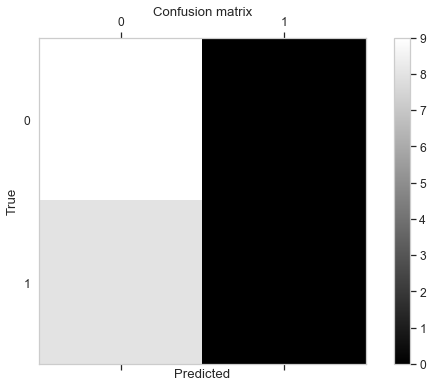

4it [03:19, 50.06s/it]

CV Split 5 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       0.00      0.00      0.00         8

    accuracy                           0.53        17
   macro avg       0.26      0.50      0.35        17
weighted avg       0.28      0.53      0.37        17

17/17 [==============================] - 0s 585us/sample - loss: 0.6911 - accuracy: 0.5294
Loss: 0.6910561919212341, Accuracy: 0.529411792755127
Confusion matrix.
[[9 0]
 [8 0]]



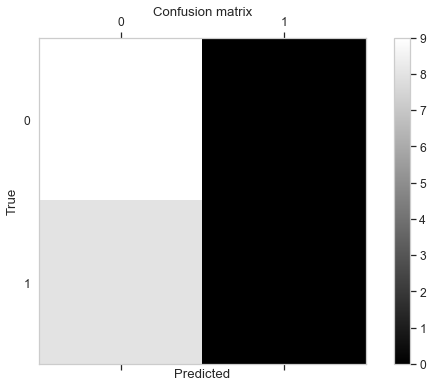

5it [04:07, 49.46s/it]

CV Split 6 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       0.00      0.00      0.00         8

    accuracy                           0.53        17
   macro avg       0.26      0.50      0.35        17
weighted avg       0.28      0.53      0.37        17

17/17 [==============================] - 0s 644us/sample - loss: 0.6914 - accuracy: 0.5294
Loss: 0.6913647651672363, Accuracy: 0.529411792755127
Confusion matrix.
[[9 0]
 [8 0]]



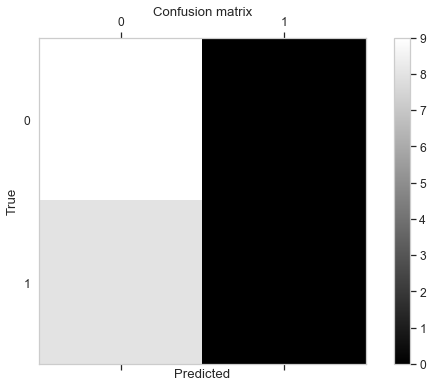

6it [04:56, 49.33s/it]

CV Split 7 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.69      1.00      0.82         9
           1       1.00      0.50      0.67         8

    accuracy                           0.76        17
   macro avg       0.85      0.75      0.74        17
weighted avg       0.84      0.76      0.75        17

17/17 [==============================] - 0s 647us/sample - loss: 0.5733 - accuracy: 0.7647
Loss: 0.5733392238616943, Accuracy: 0.7647058963775635
Confusion matrix.
[[9 0]
 [4 4]]



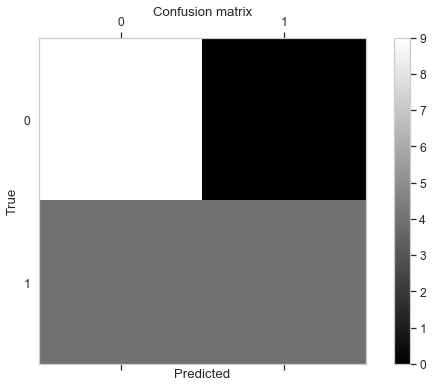

7it [05:44, 49.07s/it]

CV Split 8 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.57      0.73         7

    accuracy                           0.82        17
   macro avg       0.88      0.79      0.80        17
weighted avg       0.86      0.82      0.81        17

17/17 [==============================] - 0s 645us/sample - loss: 0.5663 - accuracy: 0.8235
Loss: 0.5663212537765503, Accuracy: 0.8235294222831726
Confusion matrix.
[[10  0]
 [ 3  4]]



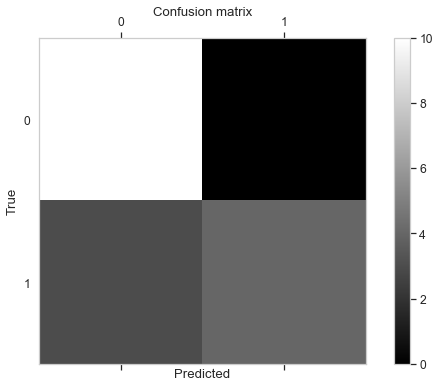

8it [05:56, 38.03s/it]

CV Split 9 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.86      0.92         7

    accuracy                           0.94        17
   macro avg       0.95      0.93      0.94        17
weighted avg       0.95      0.94      0.94        17

17/17 [==============================] - 0s 705us/sample - loss: 0.5073 - accuracy: 0.9412
Loss: 0.5073153376579285, Accuracy: 0.9411764740943909
Confusion matrix.
[[10  0]
 [ 1  6]]



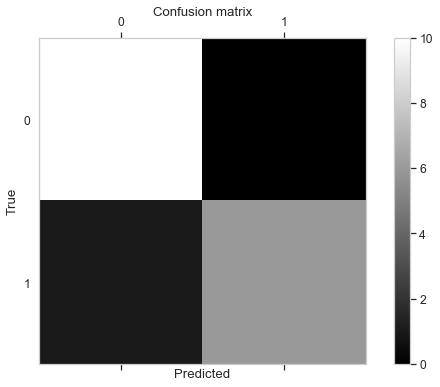

9it [06:05, 29.24s/it]

CV Split 10 ..
Evaluating split..

Classification report
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.71      0.83         7

    accuracy                           0.88        17
   macro avg       0.92      0.86      0.87        17
weighted avg       0.90      0.88      0.88        17

17/17 [==============================] - 0s 704us/sample - loss: 0.5385 - accuracy: 0.8824
Loss: 0.5385392308235168, Accuracy: 0.8823529481887817
Confusion matrix.
[[10  0]
 [ 2  5]]



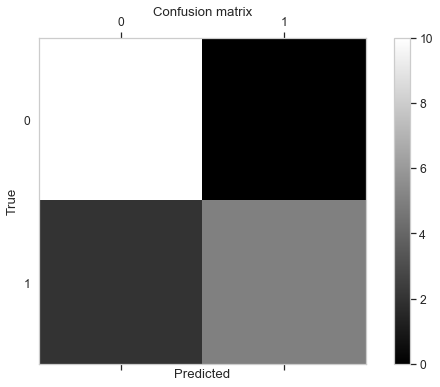

10it [06:15, 37.58s/it]


Mean classification scores...

Training accuracy: 0.661
Validation accuracy: 0.661
Training precision: 0.809
Training recall: 0.623
Training f1-score: 0.58
Validation precision: 0.52
Validation recall: 0.632
Validation f1-score: 0.544

Evaluating test set..
Classification report
              precision    recall  f1-score   support

           0       0.43      1.00      0.60        16
           1       1.00      0.22      0.36        27

    accuracy                           0.51        43
   macro avg       0.72      0.61      0.48        43
weighted avg       0.79      0.51      0.45        43

43/43 [==============================] - 0s 510us/sample - loss: 0.6390 - accuracy: 0.5116


Loss: 0.6389557331107384, Accuracy: 0.5116279125213623
Confusion matrix.
[[16  0]
 [21  6]]



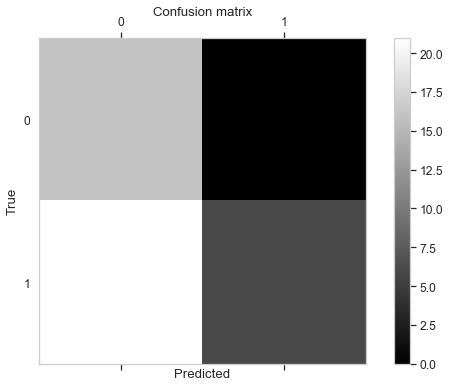

In [62]:
evaluate_time_series(wsn_train, wsn_train_target, wsn_test, wsn_test_target, opt_model)

Well, despite the overfitting problem being solved, in this case the model seems to be biased towards the ```0``` classes now to some extent. In this case, the first 6 CV splits indicate that the model is predicting only this condition, although the situation seems to normalize a bit in the other 4 splits. Even though the model performance is still poor, we can see that at the very least, the model is predicting a larger variety of classes in the test set, which is a clear sign of improvement. 

### Conclusion
<a id='section8'></a>

To summarize, the best achieved (real) classification performance seems to be with the last version of the model - a mean of <b>66%</b> validation accuracy and <b>51%</b> test accuracy. This of course, is not a great result and this iteration of the model is still underfit. However, given that we have only <b>216</b> labeled sequences to work with makes this task incredibly hard to solve, especially with neural nets, which are designed to work with a large number of samples. The large amount of variance in the sensors results in the models being incredibly sensitive to the slightest change in hyperparameters and to <b>overfitting</b> the model as a result. Even if we were to apply regularization to the model, the <b>bias-variance</b> would gradually shift from one class to the other, as can be seen in the last version, compared to the others. 

Thus, in my opinion, in order to stabilize this model more data needs to be either gathered or generated (using augmentation techniques, oversampling, etc.) to normalize this <b>bias-variance tradeoff</b>. As this also might be due to the preprocessing of the data, other padding techniques could also be explored using different padding values and thresholds, which might possibly increase the model robustness. Nonetheless, <b>time-series classification</b> is a difficult problem to handle with a low amount of samples, as the patterns inside the sequences become quite difficult to distinguish accurately, almost impossible without introducing some kind of bias in the data.